---
# **Assignment 2 for Clustering: Sessa Empirical Estimator**  
---

$\textbf{R code - Python Code}$

- $\textbf{Using the Med.Events dataset}$

In [107]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score



# Step 1: Load & Preprocess Data
file_path = "med_events.csv"
df = pd.read_csv(file_path)

df.rename(columns={
    "PATIENT_ID": "pnr",    # Patient ID
    "DATE": "eksd",         # Prescription date
    "PERDAY": "perday",     # Daily dosage
    "CATEGORY": "ATC",      # Drug type
    "DURATION": "dur_original"  # Prescription duration
}, inplace=True)

df["eksd"] = pd.to_datetime(df["eksd"], format="%m/%d/%Y")
df = df.sort_values(by=["pnr", "eksd"])

# Step 1.5: Filter Data for a Specific Drug
selected_drug = "medA"  # Change this to "medB" or another drug
df = df[df["ATC"] == selected_drug]

# Step 2: Compute Event Intervals
df["prev_eksd"] = df.groupby("pnr")["eksd"].shift(1)
df["event.interval"] = (df["eksd"] - df["prev_eksd"]).dt.days
df = df.dropna(subset=["event.interval"])

# Step 2.5: Randomly Select One Prescription Per Patient
df_filtered = df.groupby("pnr").apply(lambda x: x.sample(n=min(1, len(x)), random_state=42)).reset_index(drop=True)

df.head()

C:\Users\Michael\AppData\Local\Temp\ipykernel_12000\2935975073.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df.groupby("pnr").apply(lambda x: x.sample(n=min(1, len(x)), random_state=42)).reset_index(drop=True)


,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval
25,2,2036-03-10,4,medA,50,2036-01-20,50.0
26,2,2036-08-01,4,medA,50,2036-03-10,144.0
61,4,2032-11-27,4,medA,50,2032-05-01,210.0
62,4,2033-08-20,4,medA,50,2032-11-27,266.0
63,4,2033-08-30,4,medA,50,2033-08-20,10.0


$\textbf{ II. Generating the Emperical CDF and filtering the top 20 percent}$ 

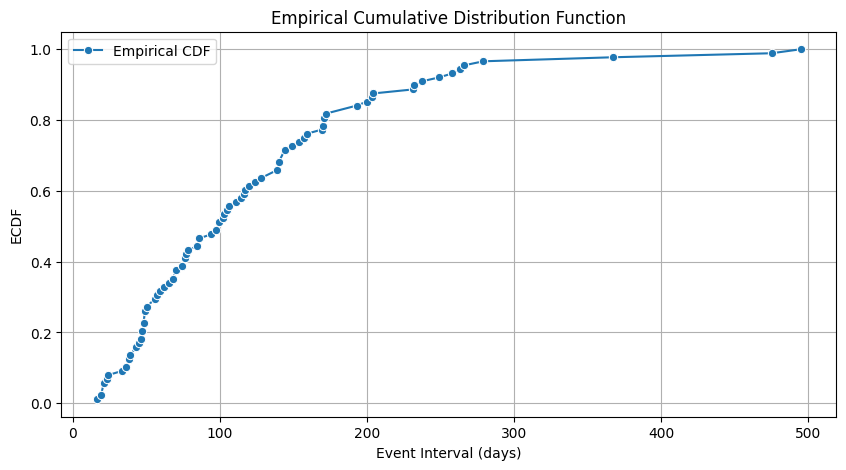

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval,Cluster
0,2,2036-08-01,4,medA,50,2036-03-10,144.0,1
2,5,2031-12-27,8,medA,30,2031-10-26,62.0,7
3,6,2037-03-24,4,medA,50,2037-01-07,76.0,2
5,8,2034-07-17,6,medA,50,2034-06-28,19.0,0
6,9,2032-08-18,2,medA,50,2032-03-01,170.0,5


In [108]:
# Step 3: Generate ECDF & Remove Top 20%
event_intervals = df_filtered["event.interval"].dropna()
ecdf = ECDF(event_intervals)
x = np.sort(event_intervals)
y = ecdf(x)

plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=y, marker="o", label="Empirical CDF")
plt.xlabel("Event Interval (days)")
plt.ylabel("ECDF")
plt.title("Empirical Cumulative Distribution Function")
plt.grid()
plt.show()

threshold = np.percentile(event_intervals, 80)  # 80th percentile cutoff
df_filtered = df_filtered[df_filtered["event.interval"] <= threshold].copy()
df_filtered["Cluster"] = kmeans.predict(scaler.transform(df_filtered[["event.interval"]]))


df_filtered.head()

$\textbf{ III. Applying K-means clustering}$ 

In [109]:
# Step 4: Apply K-Means Clustering
X = df_filtered[["event.interval"]] 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sil_scores = []
cluster_range = range(2, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, algorithm="elkan", random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

optimal_k = cluster_range[np.argmax(sil_scores)]
kmeans_final = KMeans(n_clusters=optimal_k, algorithm="elkan", random_state=42, n_init=10)
df_filtered["Cluster"] = kmeans_final.fit_predict(X_scaled)

df_filtered.head()


,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval,Cluster
0,2,2036-08-01,4,medA,50,2036-03-10,144.0,1
2,5,2031-12-27,8,medA,30,2031-10-26,62.0,0
3,6,2037-03-24,4,medA,50,2037-01-07,76.0,0
5,8,2034-07-17,6,medA,50,2034-06-28,19.0,0
6,9,2032-08-18,2,medA,50,2032-03-01,170.0,1


$\textbf{ IV. Assigning Cluster Statistics}$ 

In [110]:
# Step 5: Compute Cluster Statistics
ni2 = df_filtered.groupby("Cluster")["event.interval"].min()
ni3 = df_filtered.groupby("Cluster")["event.interval"].max()
ni4 = df_filtered.groupby("Cluster")["event.interval"].median()

cluster_stats = pd.DataFrame({
    "Cluster": ni2.index,
    "Minimum": ni2.values,
    "Maximum": ni3.values,
    "Median": ni4.values
})
cluster_stats = cluster_stats[cluster_stats["Median"] > 0]

# Step 6: Assign Patients to Clusters
results = df.merge(df_filtered[["pnr", "Cluster"]], on="pnr", how="left")

# Now merge with cluster statistics to get Minimum, Maximum, and Median values
results = results.merge(cluster_stats, on="Cluster", how="left")
results = results[(results["event.interval"] >= results["Minimum"]) & 
                  (results["event.interval"] <= results["Maximum"])]
results.dropna(subset=["Cluster"], inplace=True)

results.head()

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval,Cluster,Minimum,Maximum,Median
1,2,2036-08-01,4,medA,50,2036-03-10,144.0,1.0,94.0,171.0,133.5
6,5,2031-12-27,8,medA,30,2031-10-26,62.0,0.0,16.0,86.0,49.0
7,5,2032-01-25,8,medA,30,2031-12-27,29.0,0.0,16.0,86.0,49.0
8,5,2032-03-04,8,medA,30,2032-01-25,39.0,0.0,16.0,86.0,49.0
12,6,2037-03-24,4,medA,50,2037-01-07,76.0,0.0,16.0,86.0,49.0


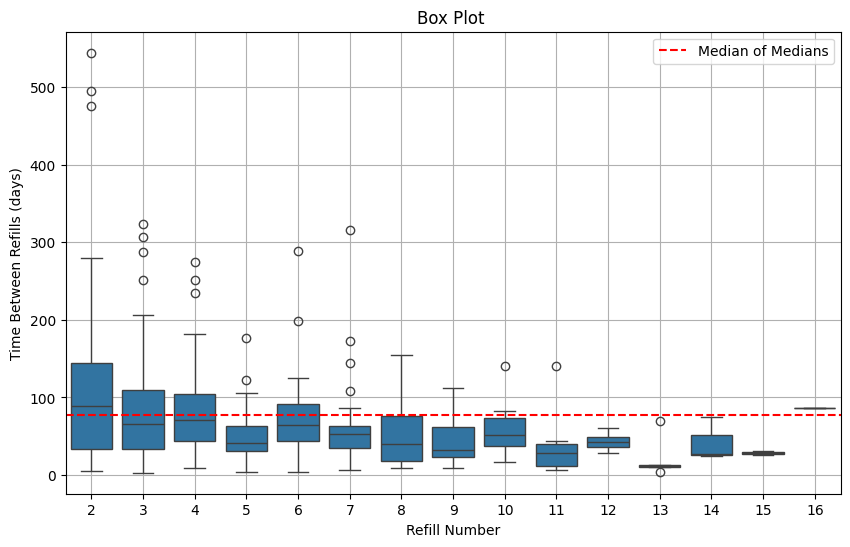

In [111]:
# Step 7: SEE Assumption Check (Whisker Plot)

# Compute refill sequence number (p_number) per patient
df["p_number"] = df.groupby("pnr").cumcount() + 1

# Filter to remove first refill, as done in R script (only p_number >= 2)
df_filtered = df[df["p_number"] >= 2].copy()

# Compute median of medians per patient
medians_of_medians = df_filtered.groupby("pnr")["event.interval"].median().median()

plt.figure(figsize=(10, 6))
sns.boxplot(x="p_number", y="event.interval", data=df_filtered)

# Add median of medians as reference line
plt.axhline(y=medians_of_medians, linestyle="dashed", color="red", label="Median of Medians")

plt.xlabel("Refill Number")
plt.ylabel("Time Between Refills (days)")
plt.title("Box Plot ")
plt.legend()
plt.grid()
plt.show()


$\textbf{ K-means Cluster Statistics}$ 

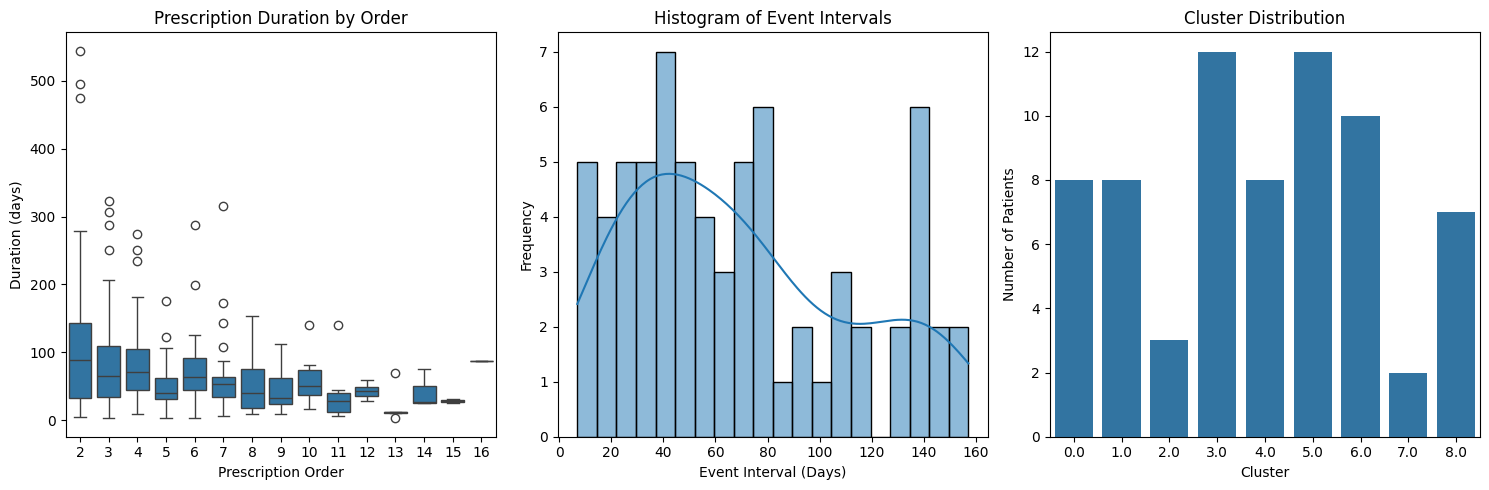

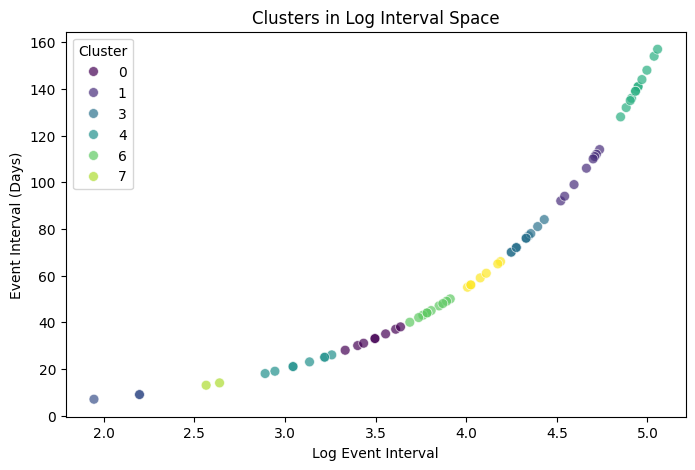

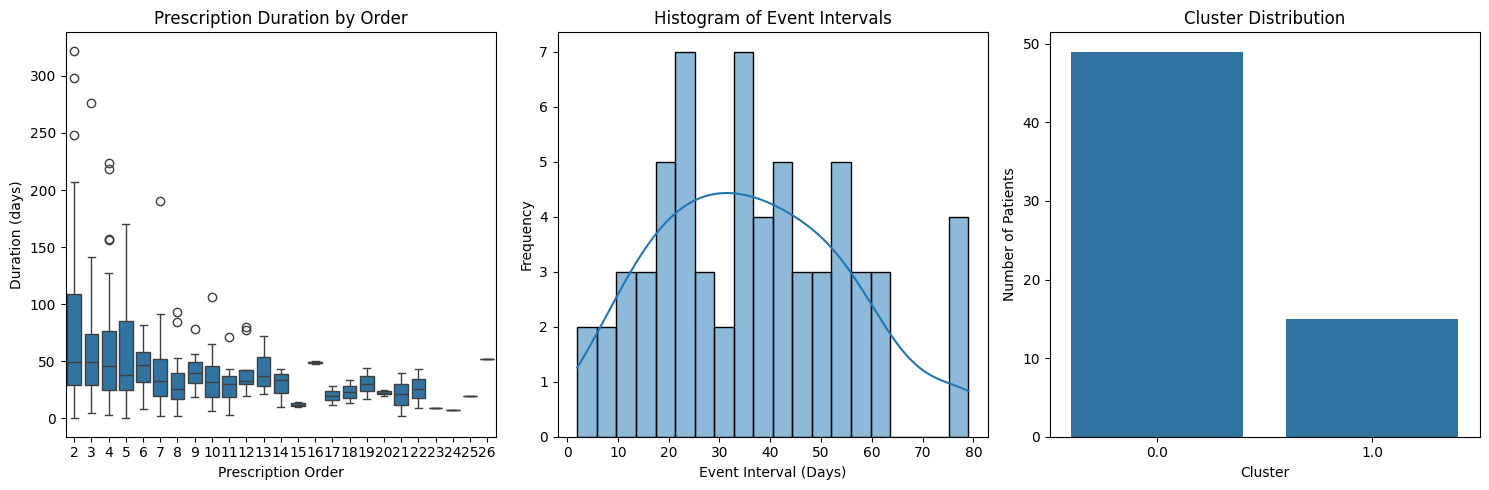

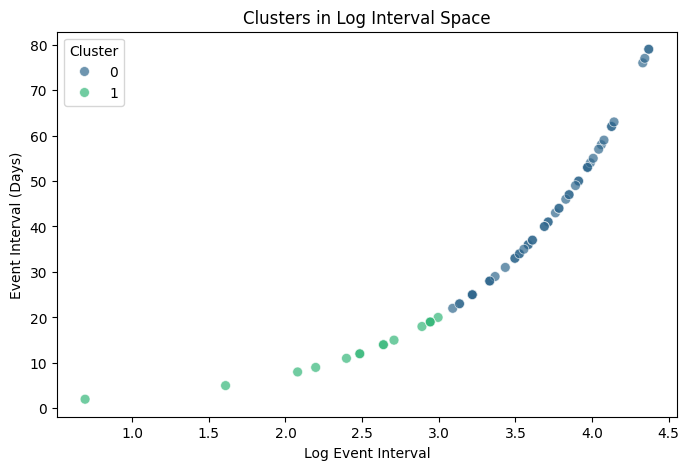

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Load CSV and ensure correct column names
df = pd.read_csv("med_events.csv")
expected_cols = ["pnr", "eksd", "perday", "ATC", "dur_original"]
if not all(col in df.columns for col in expected_cols):
    if len(df.columns) == 5:
        df.columns = expected_cols
    else:
        raise KeyError(f"CSV does not have the expected columns: {expected_cols}")

# Convert 'eksd' to datetime
df["eksd"] = pd.to_datetime(df["eksd"], errors="coerce")

def see_kmeans(drug_code, df):
    data = df[df["ATC"] == drug_code].copy()
    data.sort_values(["pnr", "eksd"], inplace=True)
    data["prev_eksd"] = data.groupby("pnr")["eksd"].shift(1)
    data = data.dropna(subset=["prev_eksd"])
    if data.empty:
        print(f"No consecutive prescriptions for {drug_code}")
        return data

    sampled = data.groupby("pnr", group_keys=False).sample(n=1, random_state=1234).reset_index(drop=True)
    sampled["event_interval"] = (sampled["eksd"] - sampled["prev_eksd"]).dt.days.astype(float)

    # ECDF and interval filtering
    sorted_intervals = np.sort(sampled["event_interval"].values)
    n = len(sorted_intervals)
    ecdf_y = np.arange(1, n + 1) / n
    df_ecdf = pd.DataFrame({"x": sorted_intervals, "y": ecdf_y})
    df_ecdf_80 = df_ecdf[df_ecdf["y"] <= 0.8]
    threshold = df_ecdf_80["x"].max() if not df_ecdf_80.empty else np.percentile(sampled["event_interval"], 80)
    valid_samples = sampled[sampled["event_interval"] <= threshold].copy()
    valid_samples = valid_samples[valid_samples["event_interval"] > 0].copy()
    valid_samples["log_interval"] = np.log(valid_samples["event_interval"])

    # K-Means clustering
    X = valid_samples["log_interval"].values.reshape(-1, 1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    best_k = 2
    best_score = -1
    for k in range(2, min(10, len(X_scaled))):
        km = KMeans(n_clusters=k, random_state=1234, n_init=10)
        labels = km.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_score = score
            best_k = k

    km_final = KMeans(n_clusters=best_k, random_state=1234, n_init=10)
    valid_samples["cluster"] = km_final.fit_predict(X_scaled)

    # Compute cluster medians
    cluster_bounds = valid_samples.groupby("cluster")["log_interval"].agg(["min", "max", "median"]).reset_index()
    cluster_bounds["median_interval"] = np.exp(cluster_bounds["median"])

    # Assign cluster to event intervals
    def assign_cluster(interval):
        if interval <= 0:
            return pd.Series([0, np.nan])
        log_val = np.log(interval)
        for _, row in cluster_bounds.iterrows():
            if row["min"] <= log_val <= row["max"]:
                return pd.Series([int(row["cluster"]), row["median_interval"]])
        return pd.Series([0, np.exp(valid_samples["log_interval"].median())])

    valid_samples[["Final_cluster", "Median"]] = valid_samples["event_interval"].apply(assign_cluster)

    # Merge clustering results
    sampled = pd.merge(sampled, valid_samples[["pnr", "Final_cluster", "Median"]], on="pnr", how="left")
    overall_median = valid_samples["event_interval"].median()
    sampled["Median"] = sampled["Median"].fillna(overall_median)
    sampled["Final_cluster"] = sampled["Final_cluster"].fillna(0).astype(int)

    # Merge results back into full dataset
    final_data = pd.merge(data, sampled[["pnr", "Median", "Final_cluster"]], on="pnr", how="left")
    final_data["Median"] = final_data["Median"].fillna(overall_median)
    final_data["Final_cluster"] = final_data["Final_cluster"].fillna(0).astype(int)
    
    return final_data, valid_samples  # Return valid_samples for graphing

def visualize_results(data, valid_samples):
    plt.figure(figsize=(15, 5))

    # Boxplot of Prescription Durations by Order
    plt.subplot(1, 3, 1)
    data_sorted = data.sort_values(["pnr", "eksd"]).copy()
    data_sorted["p_number"] = data_sorted.groupby("pnr").cumcount() + 1
    data_sorted["prev_eksd"] = data_sorted.groupby("pnr")["eksd"].shift(1)
    data_sorted = data_sorted.dropna(subset=["prev_eksd"])
    data_sorted["Duration"] = (data_sorted["eksd"] - data_sorted["prev_eksd"]).dt.days
    sns.boxplot(x="p_number", y="Duration", data=data_sorted)
    plt.title("Prescription Duration by Order")
    plt.xlabel("Prescription Order")
    plt.ylabel("Duration (days)")

    # Histogram of Event Intervals
    plt.subplot(1, 3, 2)
    sns.histplot(valid_samples["event_interval"], bins=20, kde=True)
    plt.title("Histogram of Event Intervals")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("Frequency")

    # Cluster Distribution
    plt.subplot(1, 3, 3)
    sns.countplot(x="Final_cluster", data=valid_samples)
    plt.title("Cluster Distribution")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Patients")

    plt.tight_layout()
    plt.show()

    # Scatter plot of Log Intervals and Clusters
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=valid_samples["log_interval"], y=valid_samples["event_interval"],
                    hue=valid_samples["cluster"], palette="viridis", s=50, alpha=0.7)
    plt.title("Clusters in Log Interval Space")
    plt.xlabel("Log Event Interval")
    plt.ylabel("Event Interval (Days)")
    plt.legend(title="Cluster")
    plt.show()

# Run the estimator for two drugs and visualize
medA_km, validA = see_kmeans("medA", df)
medB_km, validB = see_kmeans("medB", df)

visualize_results(medA_km, validA)
visualize_results(medB_km, validB)


$\textbf{ DBSCAN Statistics}$ 

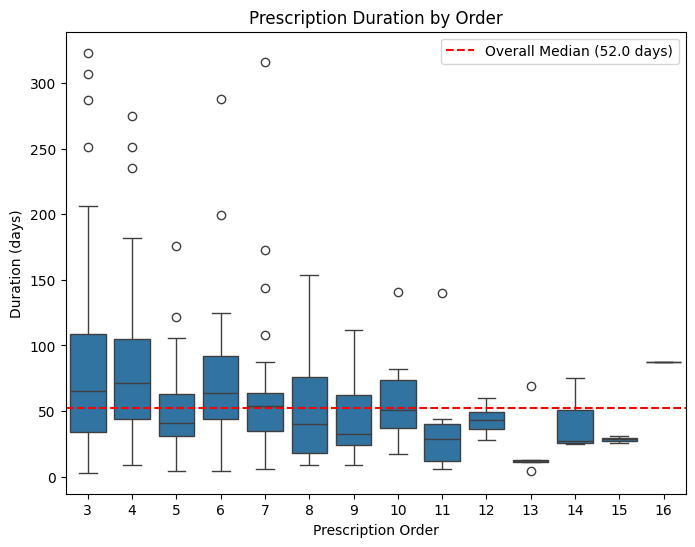

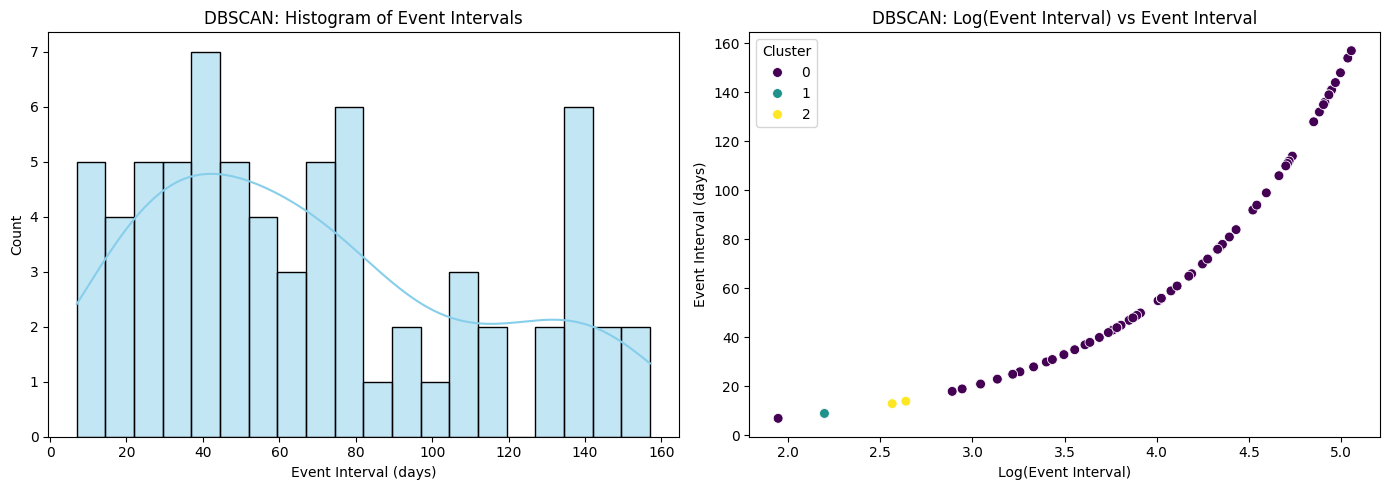

C:\Users\Michael\AppData\Local\Temp\ipykernel_12000\732720262.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=valid['cluster'], palette="coolwarm")


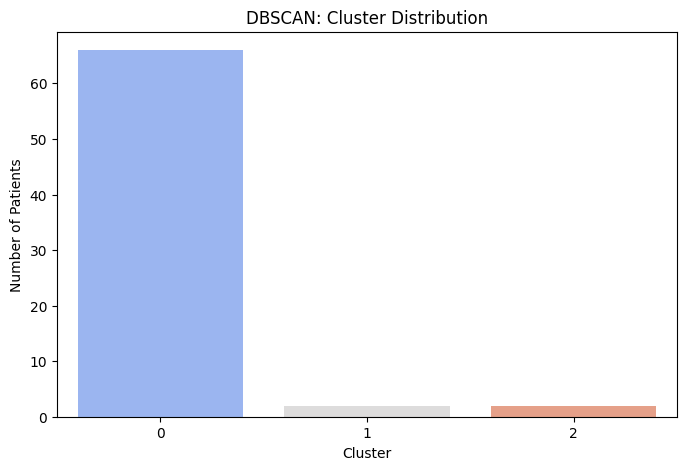

C:\Users\Michael\AppData\Local\Temp\ipykernel_12000\732720262.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='event_interval', data=valid, palette="Set2")


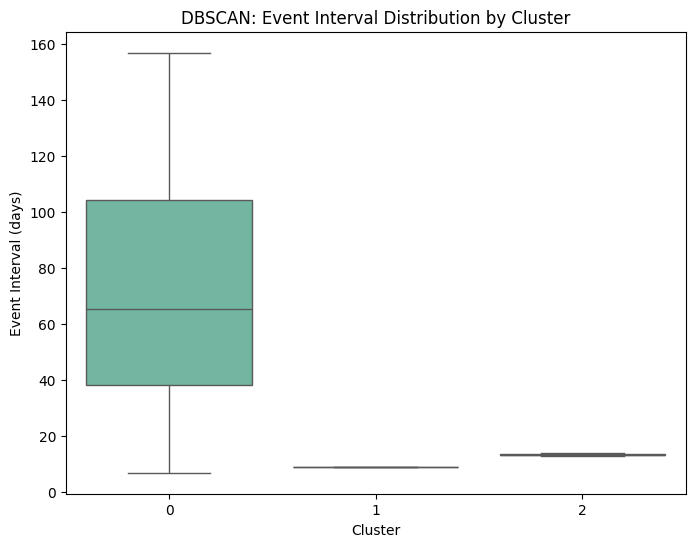

Note: DBSCAN may identify noise (cluster 0) that K-Means would not, resulting in different cluster shapes.


In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import random

# Read CSV file and ensure expected column names.
df = pd.read_csv("med_events.csv")
expected_cols = ["pnr", "eksd", "perday", "ATC", "dur_original"]
if not all(col in df.columns for col in expected_cols):
    if len(df.columns) == 5:
        df.columns = expected_cols
    else:
        raise KeyError(f"CSV does not contain the expected columns: {expected_cols}")

# Convert 'eksd' to datetime (assuming month-day-year format).
df['eksd'] = pd.to_datetime(df['eksd'], format='%m/%d/%Y', errors='coerce')

def see_dbscan(drug_code, df, eps=0.3, min_samples=2):
    # Filter data for the chosen drug code.
    data = df[df['ATC'] == drug_code].copy()
    data.sort_values(['pnr', 'eksd'], inplace=True)
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    data = data.dropna(subset=['prev_eksd']).copy()
    if data.empty:
        print(f"No consecutive prescriptions for drug code {drug_code}")
        return data, None

    # For each patient, randomly sample one consecutive pair.
    sampled = data.groupby('pnr', group_keys=False).sample(n=1, random_state=1234).reset_index(drop=True)
    sampled['event_interval'] = (sampled['eksd'] - sampled['prev_eksd']).dt.days.astype(float)

    # Build the ECDF and filter out the upper 20% of event intervals.
    intervals = np.sort(sampled['event_interval'].values)
    n = len(intervals)
    ecdf_y = np.arange(1, n+1) / n
    df_ecdf = pd.DataFrame({'x': intervals, 'y': ecdf_y})
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    threshold = df_ecdf_80['x'].max() if not df_ecdf_80.empty else np.percentile(sampled['event_interval'], 80)
    
    # Keep only samples with event_interval below the threshold (reducing outliers).
    valid = sampled[sampled['event_interval'] <= threshold].copy()
    valid = valid[valid['event_interval'] > 0].copy()
    if valid.empty:
        print("No valid event intervals after filtering.")
        return data, None

    # Log-transform the event intervals.
    valid['log_interval'] = np.log(valid['event_interval'])
    X = valid['log_interval'].values.reshape(-1, 1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply DBSCAN clustering on the log-transformed data.
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    valid['cluster'] = labels
    # DBSCAN marks noise points as -1; here we reassign them to cluster 0.
    valid.loc[valid['cluster'] == -1, 'cluster'] = 0

    # Compute the median of the log-transformed event intervals per cluster (back-transform to original scale).
    cluster_medians = valid.groupby('cluster')['log_interval'].median().apply(np.exp).reset_index()
    cluster_medians.columns = ['cluster', 'median_interval']

    # Merge the cluster assignment and median back to the sampled data.
    sampled = pd.merge(sampled, valid[['pnr', 'cluster']], on='pnr', how='left')
    sampled = pd.merge(sampled, cluster_medians, on='cluster', how='left')
    overall_median = sampled['event_interval'].median()
    sampled['median_interval'] = sampled['median_interval'].fillna(overall_median)
    sampled['cluster'] = sampled['cluster'].fillna(0).astype(int)

    # Merge the DBSCAN clustering info back into the full dataset.
    final_data = pd.merge(data, sampled[['pnr', 'median_interval', 'cluster']], on='pnr', how='left')
    final_data['median_interval'] = final_data['median_interval'].fillna(overall_median)
    final_data['cluster'] = final_data['cluster'].fillna(0).astype(int)
    return final_data, valid

def see_assumption(data):
    # Boxplot of prescription durations by order.
    data = data.sort_values(['pnr', 'eksd']).copy()
    data['p_number'] = data.groupby('pnr').cumcount() + 1
    data_assumption = data[data['p_number'] >= 2].copy()
    data_assumption['prev_eksd'] = data_assumption.groupby('pnr')['eksd'].shift(1)
    data_assumption = data_assumption.dropna(subset=['prev_eksd'])
    data_assumption['Duration'] = (data_assumption['eksd'] - data_assumption['prev_eksd']).dt.days
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='p_number', y='Duration', data=data_assumption)
    overall_median = data_assumption['Duration'].median()
    plt.axhline(overall_median, color='red', linestyle='--', label=f'Overall Median ({overall_median:.1f} days)')
    plt.title('Prescription Duration by Order')
    plt.xlabel('Prescription Order')
    plt.ylabel('Duration (days)')
    plt.legend()
    plt.show()

#######################################
# Additional Graphs Using DBSCAN Results
#######################################
def additional_dbscan_graphs(valid):
    if valid is None or valid.empty:
        print("No valid DBSCAN results available for graphing.")
        return

    # Graph 1: Histogram of Event Intervals.
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(valid['event_interval'], bins=20, kde=True, color='skyblue')
    plt.title("DBSCAN: Histogram of Event Intervals")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("Count")
    
    # Graph 2: Scatter Plot of Log-Transformed Intervals Colored by DBSCAN Cluster.
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=valid['log_interval'], y=valid['event_interval'], 
                    hue=valid['cluster'], palette="viridis", s=50)
    plt.title("DBSCAN: Log(Event Interval) vs Event Interval")
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Event Interval (days)")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()
    
    # Graph 3: Cluster Distribution (Bar Plot).
    plt.figure(figsize=(8, 5))
    sns.countplot(x=valid['cluster'], palette="coolwarm")
    plt.title("DBSCAN: Cluster Distribution")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Patients")
    plt.show()
    
    # Graph 4: Boxplot of Event Intervals by DBSCAN Cluster.
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='cluster', y='event_interval', data=valid, palette="Set2")
    plt.title("DBSCAN: Event Interval Distribution by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Event Interval (days)")
    plt.show()
    
    # Annotation: Note how DBSCAN can leave out noise points (assigned to cluster 0),
    # whereas K-Means would force every point into a cluster.
    print("Note: DBSCAN may identify noise (cluster 0) that K-Means would not, resulting in different cluster shapes.")

#######################################
# Run DBSCAN on a Drug Code and Visualize
#######################################
drug = "medA"
final_dbscan, valid_dbscan = see_dbscan(drug, df, eps=0.3, min_samples=2)

# Show boxplot of prescription durations by order.
see_assumption(final_dbscan)

# Show additional graphs based on DBSCAN clustering.
additional_dbscan_graphs(valid_dbscan)
